In [1]:
from __future__ import print_function, division
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import seaborn as sns 
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from datetime import datetime
from PIL import Image
import argparse

# 1.데이터 로드함수 작성

In [2]:
def getDevice():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

In [3]:
def getDataTransforms(input_size):
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size + 32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size + 32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }
    return data_transforms

In [4]:
def getDatasetDictionary(data_dir, data_transforms):
    image_datasets_dict = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
    return image_datasets_dict

In [5]:
def minmax_normalize_forprob(x):    
    minvector = x.min(1, keepdim=True )[0]    
    #print("minvector" , minvector )     
    sum_minvector = ( x - minvector ).sum(1, keepdim=True)
    #print("sum_minvector", sum_minvector )
    
    returnvalue = ( x - minvector ) / sum_minvector
    #print("returnvalue", returnvalue )
    #print("returnvalue", returnvalue)    
    return returnvalue

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
def show_something(dataloaders, class_names):
    inputs, classes = next(iter(dataloaders['train']))
    inputs =  inputs[:4,:,:,:]
    classes = classes[:4]
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# 2. 기존에 pretrain된 모델불러오기

In [8]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None    

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "resnet50":
        """ resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "resnet152":
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    elif model_name == "vgg19_bn":
        """ VGG19_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)        
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
    elif model_name == "densenet169":
        """ Densenet
        """
        model_ft = models.densenet169(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "densenet201":
        """ Densenet
        """
        model_ft = models.densenet201(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)                
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

# 3. 모델 학습시키기

In [9]:
def train_model(dataset_dict, model, optimizer, criterion, args):
    
    train_dataloader = torch.utils.data.DataLoader(dataset_dict['train'], batch_size = args.batch_size, shuffle=True, num_workers=4 )
    
    model.train()
    running_loss = 0.0
    running_corrects = 0

    device = getDevice()
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)                

        optimizer.zero_grad()                

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)        
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects / len(train_dataloader.dataset)    
    return model, epoch_loss, epoch_acc

In [10]:
def validate_model(dataset_dict, model, criterion, args):
    
    val_dataloader = torch.utils.data.DataLoader(dataset_dict['val'], batch_size = args.batch_size, shuffle=True, num_workers=4 )
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    device = getDevice()    
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)                        

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss = running_loss / len(val_dataloader.dataset)
    epoch_acc = running_corrects / len(val_dataloader.dataset) 
    return epoch_loss, epoch_acc

In [11]:
def test_model(dataset_dict, model, args):
    
    test_dataloader = torch.utils.data.DataLoader(dataset_dict['test'], batch_size = args.batch_size, shuffle=False, num_workers=4 )
    
    model.eval()    
    running_corrects = 0

    device = getDevice()    
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)                        

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)        
        running_corrects += torch.sum(preds == labels.data).item()
    
    epoch_acc = running_corrects / len(test_dataloader.dataset) 
    return epoch_acc

In [12]:
def evaludate_model(PATH, model_name, num_classes, data_transforms):
    # model inference 테스트 하기.
    checkpoint = torch.load(PATH)
    model_load = initialize_model(model_name, num_classes, use_pretrained=True)
    model_load.load_state_dict(checkpoint['model_state_dict'])
    model_load.eval()
    model_load = model_load.to('cpu')
    #filename = 'D:/MyProject/PyTorch/InterBookRec/datas/mylocaltarget/test/7734_40/0613144216_10_0.jpg'
    filename = 'C:/Users/10008000/__ImageProcess/images/fortrain/test/bear/00000106.jpg'
    imgdata = Image.open(filename)
    trans = data_transforms['val']
    img_trans = trans( imgdata )     

    outputs = model_load(img_trans.unsqueeze_(0))
    
    #qq = minmax_normalize_forprob( outputs )
    _, preds = torch.max(outputs, 1)
    print("preds.item()", preds.item())
    nIndex = preds.item()
    print("class_names", checkpoint["class_names"][nIndex])    

# 4. hypter parameter tuning

In [13]:
def experiment(dataset_dict, args ) :
    since = time.time()    
    
    #dataloaders, class_names, _ = getDatasetsWithClassNames( args.data_dir, args.batch_size, args.input_size )    
    
    device = getDevice()
    model = initialize_model(args.model_name, args.num_classes, use_pretrained=True)    
    model = model.to(device)    
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0    
    
    criterion = nn.CrossEntropyLoss()
    
    ##############################
    #### 데이터 리턴 부분. #######
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    #### 데이터 리턴 부분. #######
    ##############################

    for epoch in range(args.num_epochs):
        print('Epoch {}/{}'.format(epoch, args.num_epochs - 1))
        print('-' * 10)
        
        model, train_loss, train_acc = train_model(dataset_dict, model, optimizer, criterion, args)        
        val_loss, val_acc = validate_model(dataset_dict, model, criterion, args)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        
        print('train Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))
        print('val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        if val_acc > best_acc:                
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())        
                
    
    test_acc = test_model(dataset_dict, model, args)
    print('{} Acc: {:.4f}'.format('test', test_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)    
    
    # best를 저장합시다. 
    PATH = "./{}_with_class_names_{}.pt".format(args.model_name, datetime.today().strftime("%Y%m%d"))
    class_names = dataset_dict['train'].classes
    torch.save({'model_state_dict':model.state_dict(),'class_names':class_names}, PATH)    
    args.PATH = PATH
    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc    
    
    return vars(args), result      
    

# 5. 실험 관리함수

In [14]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['num_epochs']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [15]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# 실제로 테스트를 진행하기

In [16]:
seed = 888
np.random.seed(seed)
torch.manual_seed(seed)

data_dir = 'C:/Users/10008000/__ImageProcess/images/fortrain'
data_transforms = getDataTransforms(224)
dataset_dict = getDatasetDictionary( data_dir, data_transforms )

parser = argparse.ArgumentParser()
args = parser.parse_args("")  
args.exp_name='exp1_lr'
#args.device = getDevice()

batch_size = 32
input_size = 224
model_name = "resnet50"
num_classes = 10
num_epochs = 10    

args.batch_size = batch_size
args.input_size = input_size    
args.model_name = model_name
args.num_classes = num_classes
args.num_epochs = num_epochs

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_name'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = ['resnet50']

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(dataset_dict, deepcopy(args))
        save_exp_result(setting, result)      

#experiment( dataset_dict, args )
#PATH = train_val_model(args)    
#evaludate_model(PATH, model_name, num_classes, getDataTransforms(input_size) )    

Namespace(batch_size=32, exp_name='exp1_lr', input_size=224, lr=0.001, model_name='resnet50', num_classes=10, num_epochs=10)
Epoch 0/9
----------
train Loss: 0.8133 Acc: 0.7737
val Loss: 0.2158 Acc: 0.9371
Epoch 1/9
----------
train Loss: 0.3808 Acc: 0.8780
val Loss: 0.1736 Acc: 0.9441
Epoch 2/9
----------
train Loss: 0.3208 Acc: 0.8972
val Loss: 0.1562 Acc: 0.9510
Epoch 3/9
----------
train Loss: 0.2941 Acc: 0.9077
val Loss: 0.1477 Acc: 0.9497
Epoch 4/9
----------
train Loss: 0.2647 Acc: 0.9137
val Loss: 0.1432 Acc: 0.9566
Epoch 5/9
----------
train Loss: 0.2501 Acc: 0.9214
val Loss: 0.1388 Acc: 0.9497
Epoch 6/9
----------
train Loss: 0.2576 Acc: 0.9131
val Loss: 0.1387 Acc: 0.9538
Epoch 7/9
----------
train Loss: 0.2165 Acc: 0.9327
val Loss: 0.1277 Acc: 0.9594
Epoch 8/9
----------
train Loss: 0.2078 Acc: 0.9324
val Loss: 0.1326 Acc: 0.9552
Epoch 9/9
----------
train Loss: 0.1945 Acc: 0.9343
val Loss: 0.1277 Acc: 0.9552
test Acc: 0.9611
Training complete in 13m 29s
Best val Acc: 0.959

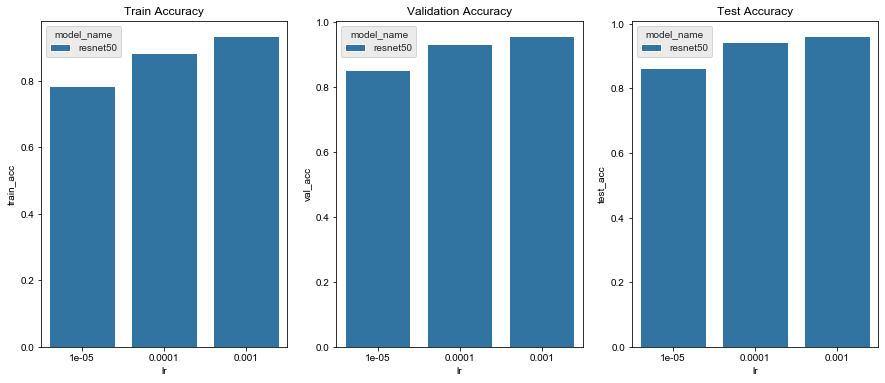

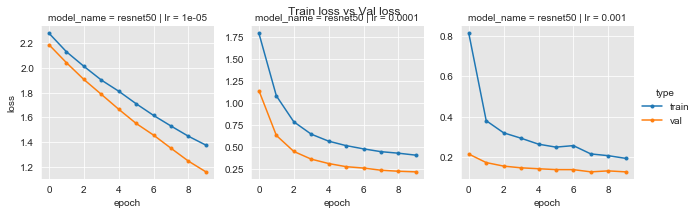

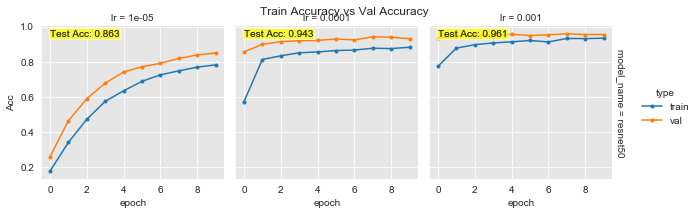

In [17]:
var1 = 'lr'
var2 = 'model_name'
df = load_exp_result('exp1_lr')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)